In [3]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math

from google.colab import files

warnings.filterwarnings("ignore")
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.23 s


In [4]:
# load df
data = pd.read_csv('filter_diff_sub.csv', sep='|')

# separate x and y
x = data.iloc[:, 12:133]
y = data.iloc[:, 4:12]
data.head()

,Type,AB,Site,Impurity,?H (A-rich),?H (B-rich),(+3/+2),(+2/+1),(+1/0),(0/-1),(-1/-2),(-2/-3),PBE_delta_H,PBE_latt_const,PBE_gap,Eps_elec,Eps_ion,Ion_rad,BP,MP,Density,At_wt,ICSD_vol,Cov_rad,Ion_Energy,At_rad_1,Elec_Aff,At_rad_2,At_vol,Mend_num,Ion_pot_1,Ion_pot_2,Thermal_expn,Sp_heat_cap,Therm_cond,Elec_cond,Heat_fusion,Heat_vap,Electronegativity,At_num,...,Ion_pot_2.2,Thermal_expn.2,Sp_heat_cap.2,Therm_cond.2,Elec_cond.2,Heat_fusion.2,Heat_vap.2,Electronegativity.2,At_num.2,Period.2,Group.2,Valence.2,Ox_state.2,Ion_rad.3,BP.3,MP.3,Density.3,At_wt.3,ICSD_vol.3,Cov_rad.3,Ion_Energy.3,At_rad_1.3,Elec_Aff.3,At_rad_2.3,At_vol.3,Mend_num.3,Ion_pot_1.3,Ion_pot_2.3,Thermal_expn.3,Sp_heat_cap.3,Therm_cond.3,Elec_cond.3,Heat_fusion.3,Heat_vap.3,Electronegativity.3,At_num.3,Period.3,Group.3,Valence.3,Ox_state.3
0,III-V,AlN,M_A,Ni,4.804,-4.723,-1.619,-0.743,0.182,2.301,3.794,5.102,-8.00,4.40,3.28,6.8,3.15,0.54,2740,933.50,2.70,26.98,16.6,1.18,577.6,1.43,45.0,1.62,10.0,73,5.99,18.83,23.1,0.90,237.0,37.7,10.70,290.80,1.61,13,...,18.17,13.4,0.44,90.70,14.6,17.20,377.50,1.91,28,4,10,3,2,0.13,1230.0,1302.50,9.71,75.93,-5.1,0.07,142.4,-0.09,75.0,0.21,-1.70,-14,1.47,-0.75,-14.9,-0.66,-87.0,-14.70,11.06,204.59,0.67,32,2,-4,3,0
1,III-V,GaN,M_A,Tl,3.863,-2.270,-1.415,-0.825,-0.162,2.739,3.742,4.839,-6.13,4.55,1.55,15.0,0.26,0.62,2478,302.92,5.91,69.72,19.6,1.26,578.8,1.41,29.0,1.81,11.8,74,6.00,20.51,19.7,0.37,40.6,1.8,5.59,256.06,1.81,31,...,20.43,29.9,0.13,46.10,5.6,4.27,162.09,2.04,81,6,13,3,1,-0.46,2622.0,3522.08,-3.65,-57.71,-14.0,-0.49,507.6,-0.50,93.3,-0.90,-7.22,3,5.26,3.87,-18.7,0.34,-38.9,-1.73,99.41,458.94,0.74,-25,-2,1,1,1
2,III-V,GaN,M_A,Bi,4.486,-1.646,-1.353,0.307,1.346,3.064,3.943,4.809,-6.13,4.55,1.55,15.0,0.26,0.62,2478,302.92,5.91,69.72,19.6,1.26,578.8,1.41,29.0,1.81,11.8,74,6.00,20.51,19.7,0.37,40.6,1.8,5.59,256.06,1.81,31,...,16.69,13.4,0.12,7.87,0.9,11.00,179.00,2.02,83,6,15,5,3,0.57,-455.0,297.73,5.44,137.48,10.7,0.21,136.7,0.34,81.0,0.00,6.37,7,1.42,-5.48,9.1,-0.24,-5.3,3.00,-0.82,-78.16,0.52,51,2,1,1,-1
3,II-VI,ZnS,M_A,Ba,2.809,4.209,-0.926,-0.474,-0.005,3.214,3.939,4.644,-2.01,5.45,2.01,5.9,3.39,0.74,1180,692.73,7.13,65.39,15.1,1.25,906.4,1.33,0.0,1.53,9.2,69,9.39,17.96,30.2,0.39,116.0,16.9,7.38,115.30,1.65,30,...,10.00,20.6,0.20,18.40,2.8,8.01,140.20,0.89,56,6,2,2,2,0.09,3695.0,1811.27,6.18,113.10,7.3,0.19,-264.4,0.23,0.0,0.63,4.40,-24,-2.74,-3.03,-24.3,-0.25,-93.0,-13.50,14.38,545.77,-0.35,42,2,-8,2,2
4,II-VI,ZnS,M_A,Sn,2.613,3.073,-1.120,0.614,1.172,3.162,3.879,4.555,-2.01,5.45,2.01,5.9,3.39,0.74,1180,692.73,7.13,65.39,15.1,1.25,906.4,1.33,0.0,1.53,9.2,69,9.39,17.96,30.2,0.39,116.0,16.9,7.38,115.30,1.65,30,...,14.63,22.0,0.23,66.60,8.7,7.20,290.37,1.96,50,5,14,4,4,-0.18,3358.0,1784.27,4.37,32.61,-0.9,0.02,-204.4,0.03,70.0,0.42,-0.70,-16,-2.11,-2.70,-22.2,-0.15,-65.4,-16.90,15.62,386.70,0.25,13,1,-5,5,5


time: 169 ms


In [5]:
# create new primary descriptor df
norm_data = x[x.columns]
trans_data = x[x.columns]-x[x.columns].min()+0.00000001

org_data = pd.DataFrame()
sqr = pd.DataFrame()
#cube = pd.DataFrame()
sqr_root = pd.DataFrame()
#cube_root = pd.DataFrame()
inverse = pd.DataFrame()
neg_sqr = pd.DataFrame()
#neg_cube = pd.DataFrame()
neg_sqr_root = pd.DataFrame()
#neg_cube_root = pd.DataFrame()
e_x = pd.DataFrame()
e_neg_x = pd.DataFrame()
lnlog = pd.DataFrame()
inv_lnlog = pd.DataFrame()

org_data[x.columns] = norm_data
sqr[x.columns + "^(2)"] = (norm_data)**2
#cube[x.columns + "^(3)"] = (norm_data)**3
sqr_root[x.columns + "^(1/2)"] = (trans_data)**(1/2)
#cube_root[x.columns + "^(1/3)"] = (trans_data)**(1/3)

inverse[x.columns + "^(-1)"] = 1/(norm_data)
neg_sqr[x.columns + "^(-2)"] = 1/((norm_data)**(2))
#neg_cube[x.columns + "^(-3)"] = 1/((norm_data)**(3))
neg_sqr_root[x.columns + "^(-1/2)"] = 1/((trans_data)**(1/2))
#neg_cube_root[x.columns + "^(-1/3)"] = 1/((trans_data)**(1/3))

e_x["e^(" + x.columns + ")"] = np.exp(norm_data)
e_x=e_x.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
#e_neg_x["e^-("+x.columns + ")"] = 1/np.exp(norm_data)
#e_neg_x=e_neg_x.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

lnlog["ln(" + x.columns + ")"] = np.log(trans_data)
# inv_lnlog["(ln(" + x.columns + "))^-1"] = 1/(np.log(trans_data))

primary_des = pd.concat([org_data, sqr, sqr_root, inverse, 
                         neg_sqr, neg_sqr_root, 
                         e_x, lnlog], axis=1)

time: 637 ms


In [6]:
def des_div_mod(df_1, df_2):
    df = pd.concat([df_1.div(i[1], axis="index") for i in df_2.iteritems()], axis=1)
    df.columns = ["/".join([i,j]) for j in df_2.columns for i in df_1.columns]
    return df

time: 2.44 ms


In [7]:
def des_mul_mod(df_1, df_2):
    df = pd.concat([df_1.mul(i[1], axis="index") for i in df_2.iteritems()], axis=1)
    df.columns = ["*".join([i,j]) for j in df_2.columns for i in df_1.columns]
    return df

time: 3.26 ms


In [8]:
#div_df = des_div_mod(primary_des, primary_des)
mul_df = des_mul_mod(primary_des, primary_des)
mul_df.shape

(809, 887364)

time: 4min 18s


In [14]:
mul_df = mul_df.fillna(0).replace([np.inf, -np.inf], 0)

time: 19.5 s


In [10]:
# download new divison dataframe
# div_df.to_csv(r"new_descriptors_div.csv")

# download new multiplication dataframe
# mul_df.to_csv(r"new_descriptors_mul_v2.csv")

time: 1.17 ms


In [11]:
#df = pd.concat([primary_des, mul_df, div_df], axis=1)
#df = div_df.copy()
#df.shape[1]

time: 630 µs


In [12]:
#df.to_csv(r"total_new_descriptors.csv")

time: 514 µs


In [54]:
# calculate pearson's correlation
r=np.empty(0)
rr = np.empty(0)
num = []
for x_index in range(mul_df.shape[1]):
    descriptor = mul_df.iloc[:, (x_index)].to_numpy()          
    for y_index in range(y.shape[1]):
        output = y.iloc[:, (y_index)].to_numpy()
        coef_r = scipy.stats.pearsonr(descriptor, output)[0]
        r = np.append(r, abs(coef_r))
    if (((r[0] > 0.42) or (r[1] > 0.46) or (r[2] > 0.425) or (r[3] > 0.5) or 
         (r[4] > 0.56) or (r[5] > 0.64) or (r[6] > 0.762) or 
         (r[7] > 0.82)) and (str(np.isnan(np.sum(r)))=="False")):    
        rr = np.append(rr, r)
        r = np.empty(0)
    else:
        num.append(x_index)
        r = np.empty(0)
r_matrix = rr.reshape((-1, 8))
column_labels = mul_df.columns
column_labels = column_labels.drop(column_labels[num])
dim = column_labels.shape[0]
print(dim)

250
time: 21min 15s


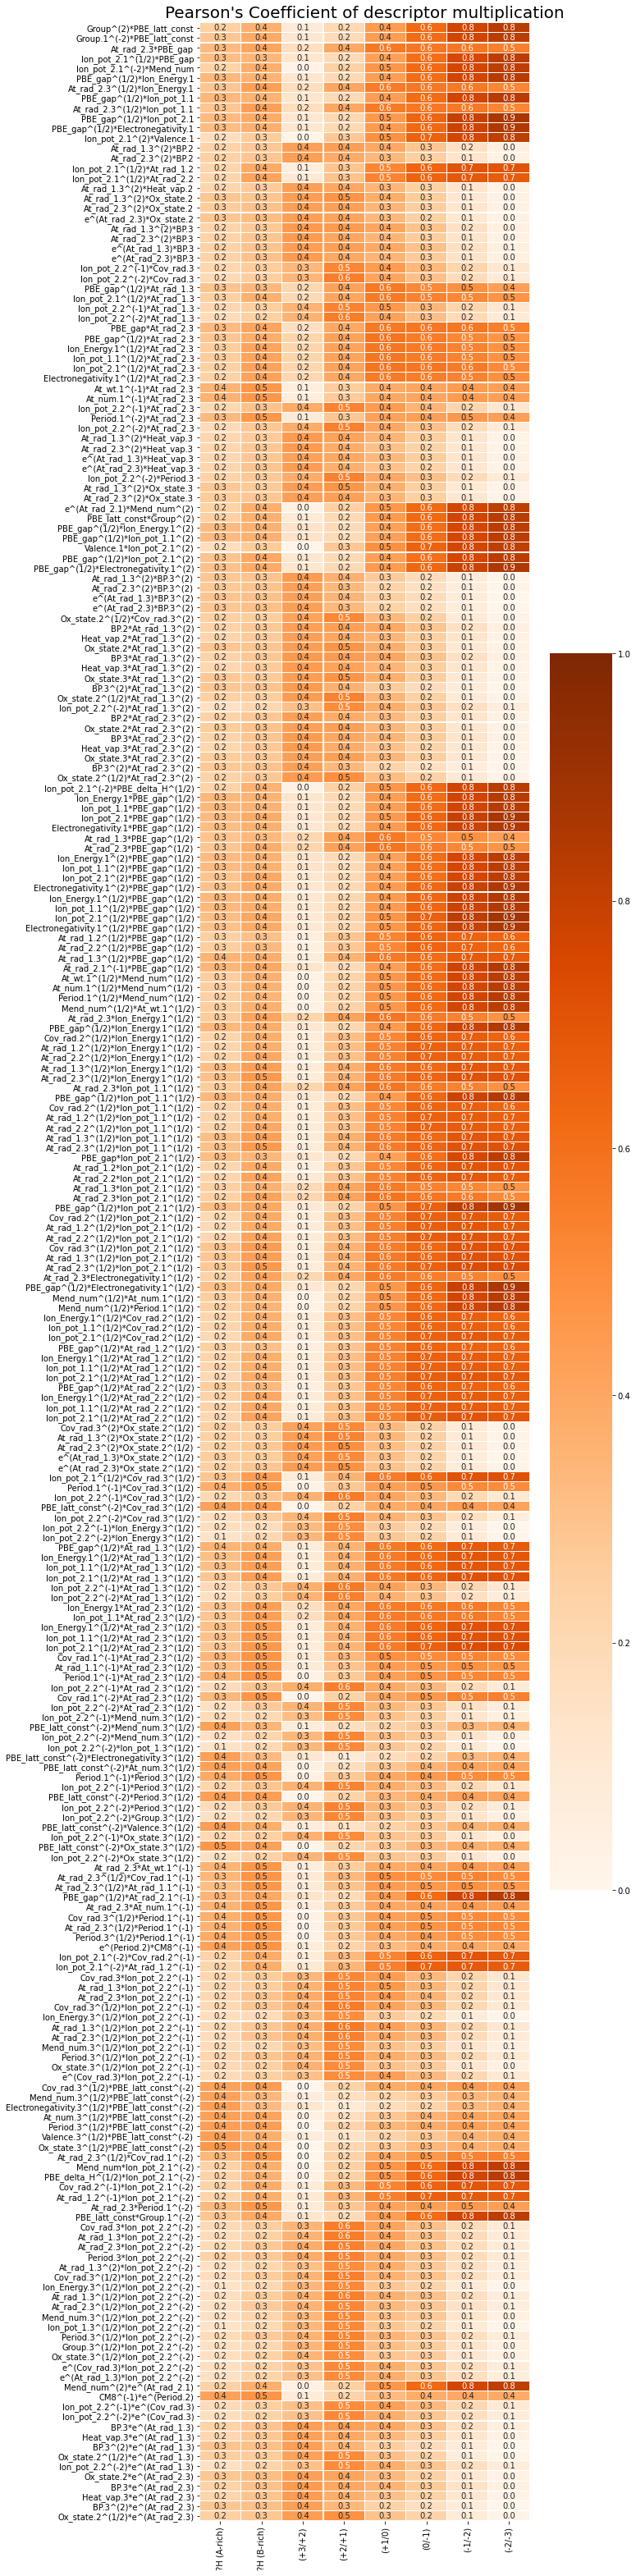

time: 12 s


In [56]:
# plot heatmap of correlation results
fig, ax1 = plt.subplots(1, 1, figsize=(9, round(dim/4.5)))
ax1.set_title("Pearson's Coefficient of descriptor multiplication", fontsize=20)
sns.heatmap(r_matrix, vmin=0, vmax=1, cmap="Oranges", linewidths=0.1,
            xticklabels=y.columns, yticklabels=column_labels, ax=ax1, 
            fmt='.1f', annot=True)

In [57]:
new_df = mul_df[column_labels]
print("Number of new descriptors: " +str(dim))
print("new df shape: " +str(new_df.shape[1]))

Number of new descriptors: 250
new df shape: 250
time: 6.98 ms


In [58]:
new_df.to_excel(r"new_descriptors_multiplication.xlsx")
files.download(r"new_descriptors_multiplication.xlsx")

time: 12.5 s


In [18]:
matrix = pd.DataFrame(r_matrix)

time: 1.72 ms
